<a href="https://colab.research.google.com/github/adytiapp/hotel_booking_cancellation/blob/main/Hotel_Booking_Clustering_Final_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to analyze the hotel booking dataset provided by kaggle. The data is originally from the article Hotel Booking Demand Datasets, written by Nuno Antonio, Ana Almeida, and Luis Nunes for Data in Brief, Volume 22, February 2019.

# Abstract

This data article describes two datasets with hotel demand data. One of the hotels (H1) is a resort hotel and the other is a city hotel (H2). Both datasets share the same structure, with 31 variables describing the 40,060 observations of H1 and 79,330 observations of H2. Each observation represents a hotel booking. Both datasets comprehend bookings due to arrive between the 1st of July of 2015 and the 31st of August 2017, including bookings that effectively arrived and bookings that were canceled. Since this is hotel real data, all data elements pertaining hotel or costumer identification were deleted. Due to the scarcity of real business data for scientific and educational purposes, these datasets can have an important role for research and education in revenue management, machine learning, or data mining, as well as in other fields.

# Data Preparation and Cleaning

Preparation

In [ ]:
!pip install kmodes

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import pickle


from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

RANDOM_STATE = 42

Load Data

In [ ]:
sheet_url = 'https://docs.google.com/spreadsheets/d/16Jzc85cRYt-mkiPBsVqikE6BZPEp5vsDYR_IO-hguC0/edit#gid=1327380804'
sheet_url_trf = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
df_ori = pd.read_csv (sheet_url_trf)
df_ori.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,7/3/2015


Making a copy so the original dataset isn't affected

In [ ]:
df = df_ori.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

Dropping Irrelevant Values

In [ ]:
df = df.drop(['agent','company'],axis=1)

Handling Missing Data

In [ ]:
df.isna().sum()

hotel                               0
is_canceled                         0
lead_time                           0
arrival_date_year                   0
arrival_date_month                  0
arrival_date_week_number            0
arrival_date_day_of_month           0
stays_in_weekend_nights             0
stays_in_week_nights                0
adults                              0
children                            4
babies                              0
meal                                0
country                           488
market_segment                      0
distribution_channel                0
is_repeated_guest                   0
previous_cancellations              0
previous_bookings_not_canceled      0
reserved_room_type                  0
assigned_room_type                  0
booking_changes                     0
deposit_type                        0
days_in_waiting_list                0
customer_type                       0
average_daily_rate                  0
required_car

In [ ]:
df = df.dropna()
df.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
average_daily_rate                0
required_car_parking_spaces       0
total_of_special_requests   

In [ ]:
df.shape

(118898, 30)

Transforming Data

In [ ]:
#Converting arrival_date to timeseries

#Combine the date data
df ['arrival_date'] = df ['arrival_date_day_of_month'].astype(str) + '-' + df ['arrival_date_month'] + '-' + df ['arrival_date_year'].astype(str)

#Converting the data type to timeseries
from datetime import datetime
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

#Changing arrival_date_month
df = df.drop(['arrival_date_month'],axis=1)
df['arrival_date_month'] = df['arrival_date'].dt.month

#Dropping unnecesarry collumn
df = df.drop(['arrival_date_day_of_month'],axis=1)

In [ ]:
#Combining day stays
df['total_day_stays'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

#Dropping aforementioned collumns
#df = df.drop(['stays_in_week_nights','stays_in_weekend_nights'],axis=1)

In [ ]:
#Combining amount of guests
df['total_guests'] = df['adults'] + df['children'] + df['babies']

#Dropping aforementioned collumns
#df = df.drop(['adults','children','babies'],axis=1)

#Changing datatype from float to int
cols = ['total_guests']
df[cols] = df[cols].applymap(np.int64)

In [ ]:
df['children'] = df['children'].astype(int)

In [ ]:
cat_columns = ['hotel']

for i in cat_columns:
  df[i] = df[i].astype('category')
  df[i] = df[i].cat.codes

In [ ]:
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

In [ ]:
df.columns = df.columns.map(camel_to_snake)

In [ ]:
features = ['meal', 'reserved_room_type', 'assigned_room_type', 'deposit_type']
for feature in features: 
    df[feature] = df[feature].str.strip()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118898 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           118898 non-null  int8          
 1   is_canceled                     118898 non-null  int64         
 2   lead_time                       118898 non-null  int64         
 3   arrival_date_year               118898 non-null  int64         
 4   arrival_date_week_number        118898 non-null  int64         
 5   stays_in_weekend_nights         118898 non-null  int64         
 6   stays_in_week_nights            118898 non-null  int64         
 7   adults                          118898 non-null  int64         
 8   children                        118898 non-null  int64         
 9   babies                          118898 non-null  int64         
 10  meal                            118898 non-null  object 

In [ ]:
df.describe()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,average_daily_rate,required_car_parking_spaces,total_of_special_requests,arrival_date_month,total_day_stays,total_guests
count,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,...,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000
mean,0.333025,0.371352,104.311435,2016.157656,27.166555,0.928897,2.502145,1.858391,0.104207,0.007948,...,0.087142,0.131634,0.221181,2.330754,102.003243,0.061885,0.571683,6.552886,3.431042,1.970546
std,0.471297,0.483168,106.903309,0.707459,13.589971,0.996216,1.900168,0.578576,0.399172,0.097380,...,0.845869,1.484672,0.652785,17.630452,50.485862,0.244172,0.792678,3.087050,2.544938,0.721894
min,0.000000,0.000000,0.000000,2015.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,18.000000,2016.000000,16.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,4.000000,2.000000,2.000000
50%,0.000000,0.000000,69.000000,2016.000000,28.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000,7.000000,3.000000,2.000000
75%,1.000000,1.000000,161.000000,2017.000000,38.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000,9.000000,4.000000,2.000000
max,1.000000,1.000000,737.000000,2017.000000,53.000000,16.000000,41.000000,55.000000,10.000000,10.000000,...,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000,12.000000,57.000000,55.000000


Interpretation: The adr feature (average daily rate) seems to have outliers. With a minimum of -6.38 and a maximum of 5400. A negative ADR could be possible if a hotel had to compensate a guest for some reason. While those numbers are surprising, we do not have enough information to assure that those observations are not accurate datapoints.

Note: For modeling puposes, we ran our model with and without those outliers and removing them lead to a decrease in predictive power. As a result, we did not remove those observations.

Visualizing Corellation Coefficients

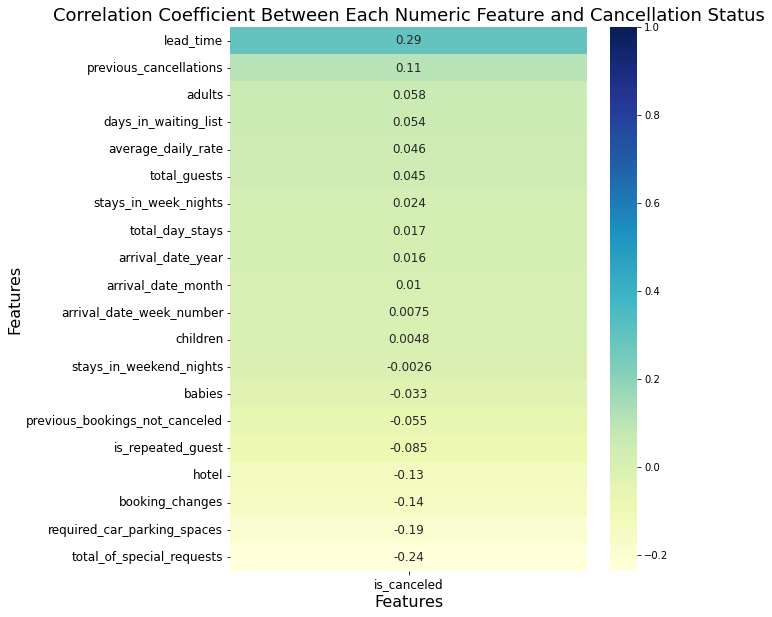

In [ ]:
# Visualizing correlation coefficients between features and cancellation:
fig = plt.figure(figsize=(8,10))
ax = sns.heatmap(df.corr()[['is_canceled']].sort_values('is_canceled', ascending=False), annot = True, annot_kws = {"size":12}, cmap='YlGnBu')
ax.set_title('Correlation Coefficient Between Each Numeric Feature and Cancellation Status', fontsize=18)
ax.set_xlabel('Features', fontsize = 16)
ax.set_ylabel('Features', fontsize = 16)
ax.tick_params(axis = "both", labelsize = 12);
y_min, y_max = ax.get_ylim()
ax.set_ylim(top=y_max+1);

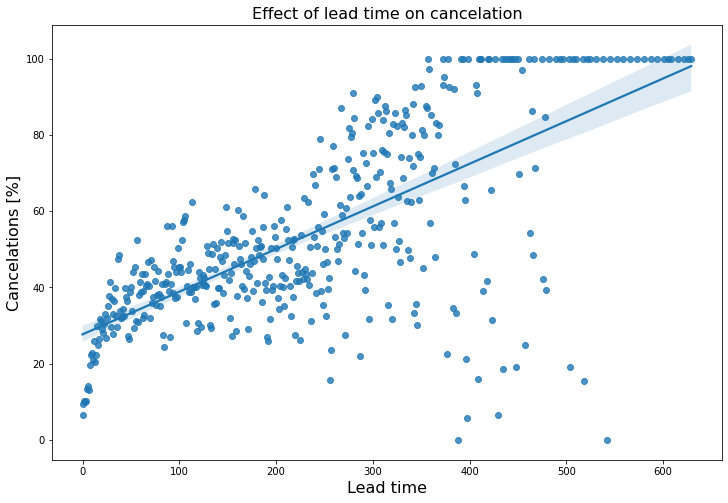

In [ ]:
# group data for lead_time:
lead_cancel_data = df.groupby("lead_time")["is_canceled"].describe()
# use only lead_times wih more than 10 bookings for graph:
lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data["count"] >= 10]

#show figure:
plt.figure(figsize=(12, 8))
sns.regplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10["mean"].values * 100)
plt.title("Effect of lead time on cancelation", fontsize=16)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
# plt.xlim(0,365)
plt.show()

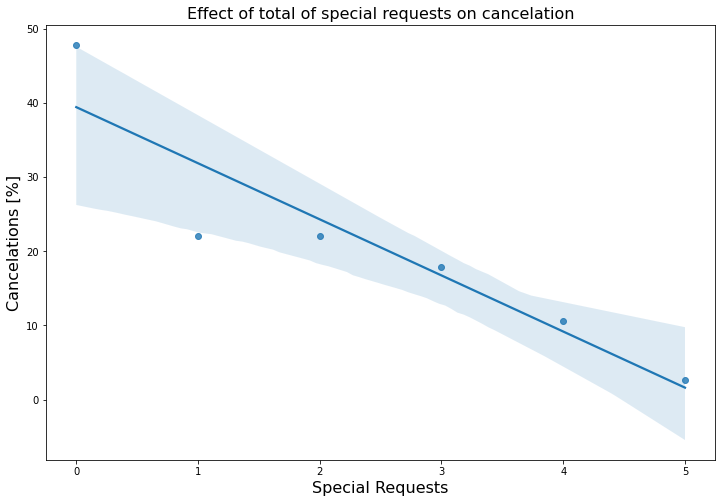

In [ ]:
# group data for special requests:
requests_cancel_data = df.groupby("total_of_special_requests")["is_canceled"].describe()

#show figure:
plt.figure(figsize=(12, 8))
sns.regplot(x=requests_cancel_data.index, y=requests_cancel_data["mean"].values * 100)
plt.title("Effect of total of special requests on cancelation", fontsize=16)
plt.xlabel("Special Requests", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
# plt.xlim(0,365)
plt.show()

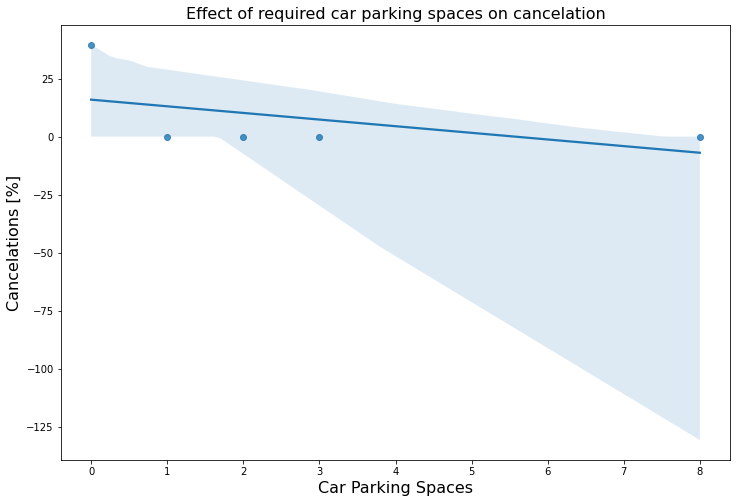

In [ ]:
# group data for parking spaces:
parking_cancel_data = df.groupby("required_car_parking_spaces")["is_canceled"].describe()

#show figure:
plt.figure(figsize=(12, 8))
sns.regplot(x=parking_cancel_data.index, y=parking_cancel_data["mean"].values * 100)
plt.title("Effect of required car parking spaces on cancelation", fontsize=16)
plt.xlabel("Car Parking Spaces", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
# plt.xlim(0,365)
plt.show()

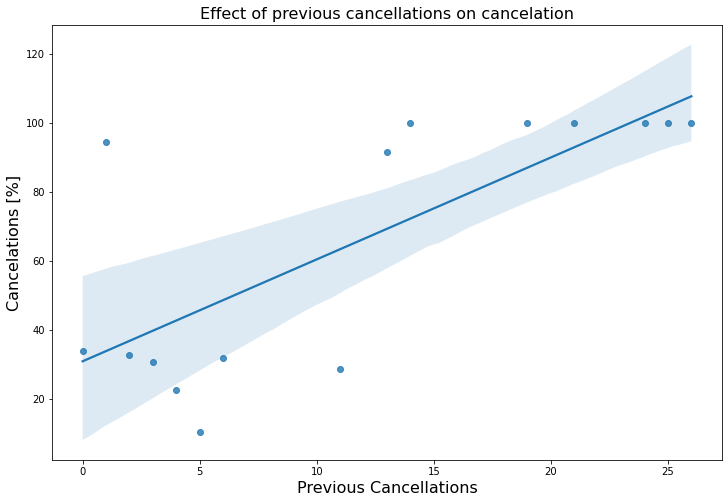

In [ ]:
# group data for prev cancellations:
prev_cancel_data = df.groupby("previous_cancellations")["is_canceled"].describe()

#show figure:
plt.figure(figsize=(12, 8))
sns.regplot(x=prev_cancel_data.index, y=prev_cancel_data["mean"].values * 100)
plt.title("Effect of previous cancellations on cancelation", fontsize=16)
plt.xlabel("Previous Cancellations", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
# plt.xlim(0,365)
plt.show()

# Clustering

We do not want to leak any information about our target (cancellation) into our clusters since those clusters will later be used as features in our predictive model. As a result, we must remove is_canceled, reservation_status, and country from our X variable.

The agent and company IDs recorded in the agent and company features include a large amount of categorical data that is de-identified and therefore difficult to interpret. As a result, those features were not included in the clustering model. Finally, as models cannot take in datetime objects as features, the reservation_status_date and arrival_date_full features were also excluded from the clustering model. It is worth noting that information about the arrival date is still included in the clustering model thanks to the arrival_date_year, arrival_date_month, and arrival_date_day_of_month features.

In [ ]:
X = df.drop(columns=['is_canceled', 'reservation_status', 'country', 'reservation_status_date', 'arrival_date'])
X.head()

,hotel,lead_time,arrival_date_year,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces,total_of_special_requests,arrival_date_month,total_day_stays,total_guests
0,1,342,2015,27,0,0,2,0,0,BB,...,3,No Deposit,0,Transient,0.0,0,0,7,0,2
1,1,737,2015,27,0,0,2,0,0,BB,...,4,No Deposit,0,Transient,0.0,0,0,7,0,2
2,1,7,2015,27,0,1,1,0,0,BB,...,0,No Deposit,0,Transient,75.0,0,0,7,1,1
3,1,13,2015,27,0,1,1,0,0,BB,...,0,No Deposit,0,Transient,75.0,0,0,7,1,1
4,1,14,2015,27,0,2,2,0,0,BB,...,0,No Deposit,0,Transient,98.0,0,1,7,2,2


Since our data is a mix of categorical and numeric features, K-prototypes is the most appropriate model to create clusters.
Note: K-Means, DBSCAN, and KModes were also tested but not shown in this notebook as Kprototypes was the best suited for our data.

# K Prototypes

In order to identify the best number of clusters to create, we need to evaluate the K-Protypes costs for different numbers of clusters. Here, we will try creating 3 to 7 clusters.

In [ ]:
# Creating a loop to try our different number of clusters: 
kproto_costs = []
for n in range(3, 7):
    #do the clustering 
    kproto = KPrototypes(n_clusters=n, init='Huang', verbose=0, random_state=RANDOM_STATE, n_jobs=-1)
    clusters = kproto.fit_predict(X, categorical=[9, 10, 11, 12, 13, 15, 16, 18, 20])
    print(f'cost: {kproto.cost_}')
    print(f'iter: {kproto.n_iter_}')
    
    # get cost 
    cost = kproto.cost_
    
    #gather them
    kproto_costs.append((n, cost))

cost: 603231982.4713265
iter: 19
cost: 480204092.1957018
iter: 12
cost: 416528404.0894939
iter: 56
cost: 370936763.9491601
iter: 26


In [ ]:
# Creating a dataframe for our K-Prototypes clusters: 
kproto_costs_df = pd.DataFrame(kproto_costs, columns=['n', 'cost'])
kproto_costs_df

,n,cost
0,3,6.032320e+08
1,4,4.802041e+08
2,5,4.165284e+08
3,6,3.709368e+08


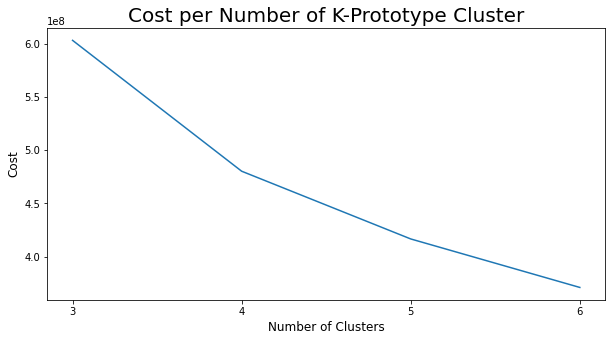

In [ ]:
# Visualizing the K-prototype costs:
plt.figure(figsize=(10,5))
plt.plot(kproto_costs_df['n'], kproto_costs_df['cost'])
plt.xticks([3,4,5,6])
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Cost', size=12)
plt.title('Cost per Number of K-Prototype Cluster', size=20);

In [ ]:
# Creating the 4 customer clusters:
kproto_4 = KPrototypes(n_clusters=4, init='Huang', verbose=0, random_state=RANDOM_STATE, n_jobs=-1)
clusters = kproto_4.fit_predict(X, categorical=[9, 10, 11, 12, 13, 15, 16, 18, 20])
print(f'cost: {kproto_4.cost_}')

cost: 480204092.1957018


In [ ]:
# Pickling the kproto_4 model: 
pickle.dump(kproto_4, open('../models/kproto_4.p', 'wb'))

FileNotFoundError: ignored

In [ ]:
# Creating a "clusters" feature in our dataset:
df['clusters'] = clusters

In [ ]:
pd.set_option('display.max_rows', None)
df.groupby(df['clusters']).describe(include='all').T

/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/groupby.py:1973: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  result = self.apply(lambda x: x.describe(**kwargs))
/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/groupby.py:1973: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  result = self.apply(lambda x: x.describe(**kwargs))
/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/groupby.py:1973: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime

clusters                                                 0  \
hotel                          count               14311.0   
                               unique                  NaN   
                               top                     NaN   
                               freq                    NaN   
                               first                   NaN   
                               last                    NaN   
                               mean                0.25966   
                               std                0.438464   
                               min                     0.0   
                               25%                     0.0   
                               50%                     0.0   
                               75%                     1.0   
                               max                     1.0   
is_canceled                    count               14311.0   
                               unique                  NaN   
                               top                     NaN   
                               freq                    NaN   
                               first                   NaN   
                               last                    NaN   
                               mean                0.64426   
                               std                0.478754   
                               min                     0.0   
                               25%                     0.0   
                               50%                     1.0   
                               75%                     1.0   
                               max                     1.0   
lead_time                      count               14311.0   
                               unique                  NaN   
                               top                     NaN   
                               freq                    NaN   
                               first                   NaN   
                               last                    NaN   
                               mean              327.02837   
                               std               73.037293   
                               min                   235.0   
                               25%                   275.0   
                               50%                   306.0   
                               75%                   356.5   
                               max                   737.0   
arrival_date_year              count               14311.0   
                               unique                  NaN   
                               top                     NaN   
                               freq                    NaN   
                               first                   NaN   
                               last                    NaN   
                               mean            2016.047516   
                               std                0.730856   
                               min                  2015.0   
                               25%                  2016.0   
                               50%                  2016.0   
                               75%                  2017.0   
                               max                  2017.0   
arrival_date_week_number       count               14311.0   
                               unique                  NaN   
                               top                     NaN   
                               freq                    NaN   
                               first                   NaN   
                               last                    NaN   
                               mean              31.684578   
                               std               10.341243   
                               min                     1.0   
                               25%                    25.0   
                               50%                    32.0   
                               7

In [ ]:
datatoexcel = pd.ExcelWriter('hoteldata_rev2.xlsx')
df.to_excel(datatoexcel)
datatoexcel.save()